In [1]:
#hide
%load_ext autoreload
%autoreload 2

# Encoder - MVP

> Self supervised learning masked value prediction as a way to create the embeddings

In [2]:
from tsai.all import *
from tchub.all import *
import wandb
from fastai.callback.wandb import WandbCallback

In [3]:
config = AttrDict(
    use_wandb = True, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = 'vrodriguezf90',
    wandb_project = 'tchub',
    train_artifact = 'taxi:v4',
    valid_artifact = 'taxi:v4',
    w = 48, # window size for the sliding window
    stride = 1, # n datapoints the window is moved ahead along the sequence in the sliding window
    output_filter_size = 10,
    batch_size = 256,
    epochs = 50
)

In [4]:
#hide
run = wandb.init(entity = config.wandb_entity,
                      # work-nbs is a place to log draft runs
                      project=config.wandb_project if config.use_wandb else 'work-nbs',
                      group=config.wandb_group,
                      job_type='encoder_MVP',
                      allow_val_change=True,
                      mode='online', # Need to be always online to download artifacts
                      config=config,
                      # When use_wandb is false the run is not linked to a personal account
                      #NOTE: This is not working right now
                      anonymous = 'never' if config.use_wandb else 'must',
                      resume=False)
config = run.config  # Object for storing hyperparameters

wandb: Currently logged in as: vrodriguezf90 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaError: Expected exactly one `egg-info` directory in '/home/victor/work', via egg-link 'lib/python3.8/site-packages/tchub.egg-link'. Instead found: ('timecluster_hub.egg-info', 'tchub.egg-info').  These are often left over from legacy operations that did not clean up correctly.  Please remove all but one of these.



In [5]:
train_artifact = run.use_artifact(f'{config.wandb_project}/{config.train_artifact}')
valid_artifact = run.use_artifact(f'{config.wandb_project}/{config.valid_artifact}')
df_train = train_artifact.to_df()
df_val = valid_artifact.to_df()
df_train.shape, df_val.shape

((3600, 1), (3600, 1))

In [6]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
X_train, _ = sw(df_train)
X_valid, _ = sw(df_val)

print(f'Training shape: {X_train.shape}')
print(f'Validation shape: {X_valid.shape}')

Training shape: (3553, 1, 48)
Validation shape: (3553, 1, 48)


In [7]:
# y is not needed, but something is breaking in the dataloaders if we do not incldue it
X, _, splits  = combine_split_data(xs=[X_train, X_valid])
splits

((#3553) [0,1,2,3,4,5,6,7,8,9...],
 (#3553) [3553,3554,3555,3556,3557,3558,3559,3560,3561,3562...])

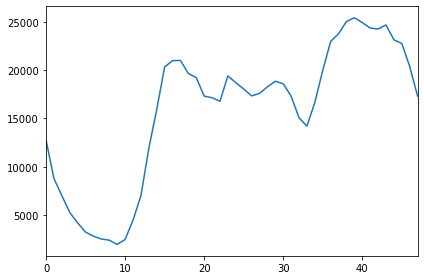

In [8]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.show_at(0)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,time
0,0.307372,0.167317,00:02
1,0.184395,0.114520,00:02
2,0.132679,0.082707,00:02
3,0.103793,0.076287,00:02
4,0.084074,0.059980,00:02
5,0.071897,0.065232,00:02
6,0.062102,0.049815,00:02
7,0.056708,0.050011,00:02
8,0.054154,0.057494,00:02
9,0.048738,0.042089,00:02


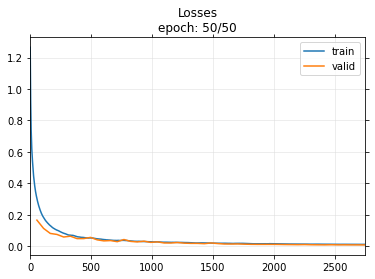

best epoch:  49  val_loss: 0.009801 - pretrained weights_path='models/encoder_MVP.pth'


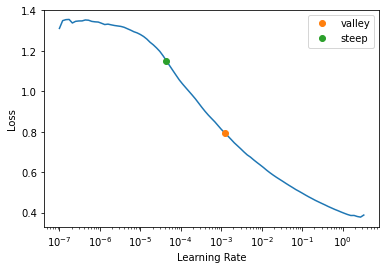

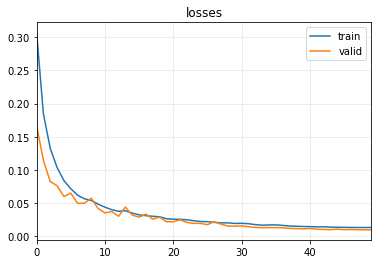

In [9]:
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs=[ShowGraph(), 
                        WandbCallback(log_preds=False),
                        MVP(r = 0.5, target_dir='./models', fname=f'encoder_MVP')])
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
learn.fit_one_cycle(n_epoch=50, lr_max=lr_valley)

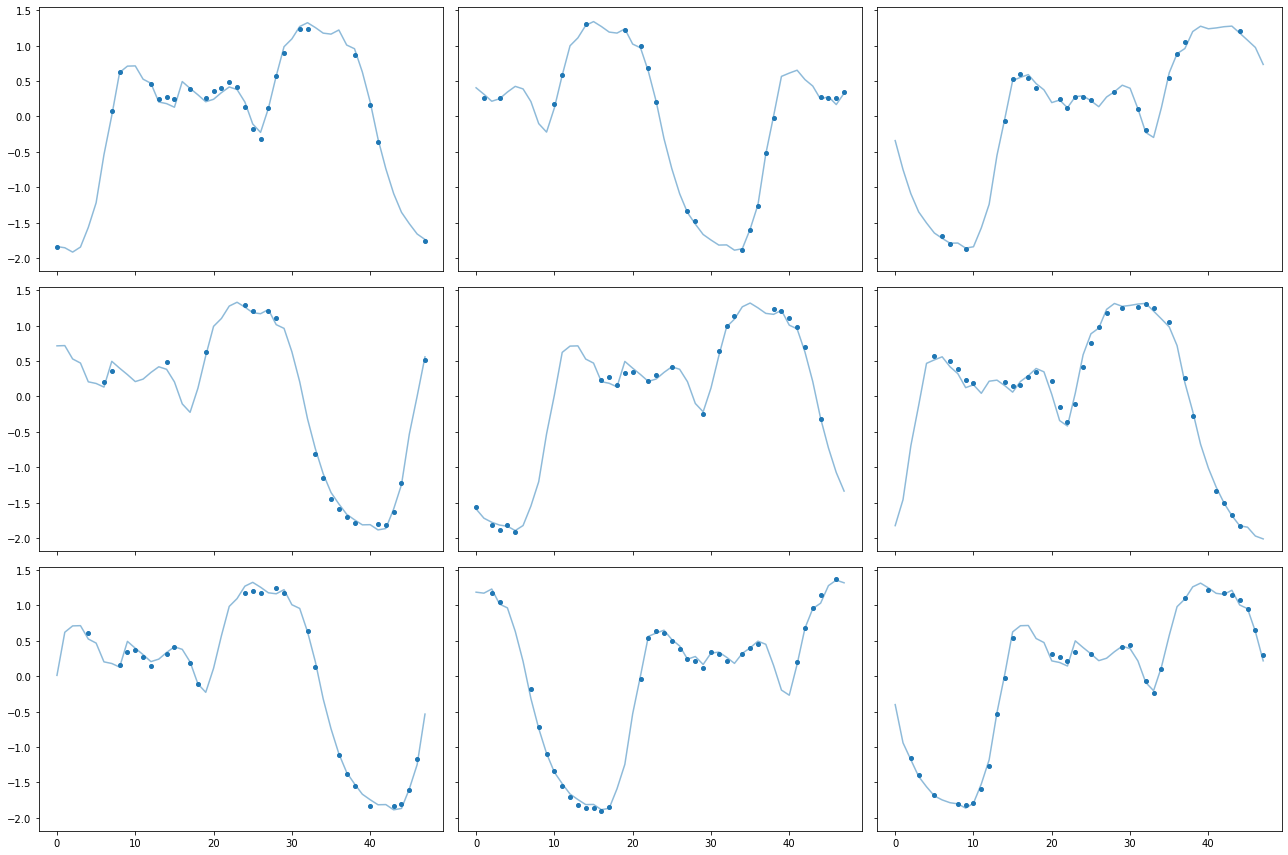

In [10]:
learn.MVP.show_preds(sharey=True)

In [11]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
run.log_artifact(ReferenceArtifact(aux_learn, f'learner-mvp'), aliases=f'run-{run.project}-{run.id}')

In [12]:
run.finish()

epoch,50
train_loss,0.0134
raw_loss,0.01574
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▅▄▄▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
